# IMPORTING LIBRARIES

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
import distance
from os import path
from wordcloud import WordCloud, STOPWORDS
from sklearn.manifold import TSNE
import plotly.graph_objs as go
import plotly.offline as py

import time
import warnings
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import sys
from tqdm import tqdm

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv("C:/Users/tapas/Documents/machine learninng/datasets/quora-question-pairs/train/train.csv")

In [3]:
df.head(10)

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   
5   5    11    12  Astrology: I am a Capricorn Sun Cap moon and c...   
6   6    13    14                                Should I buy tiago?   
7   7    15    16                     How can I be a good geologist?   
8   8    17    18                    When do you use シ instead of し?   
9   9    19    20  Motorola (company): Can I hack my Charter Moto...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0  
5  I'm a triple Capricorn (Sun, Moon and ascendan...             1  
6  What keeps childern active and far from phone ...             0  
7          What should I do to be a great geologist?             1  
8              When do you use "&" instead of "and"?             0  
9  How do I hack Motorola DCX3400 for free internet?             0

In [4]:
df.shape

(404290, 6)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [6]:
print('Total number of question pair : {}'.format(df.shape[0]))
print('Total number of nonduplicate question pair : {}'.format(len(df[df['is_duplicate']==0])))
print('Total percentage of nonduplicate question pair : {}'.format(round(len(df[df['is_duplicate']==0])*100/df.shape[0],2))+' %')
print('Total number of duplicate question pair : {}'.format(len(df[df['is_duplicate']==1])))
print('Total percentage of duplicate question pair : {}'.format(round(len(df[df['is_duplicate']==1])*100/df.shape[0],2))+' %')


Total number of question pair : 404290
Total number of nonduplicate question pair : 255027
Total percentage of nonduplicate question pair : 63.08 %
Total number of duplicate question pair : 149263
Total percentage of duplicate question pair : 36.92 %


In [7]:
round(len(df[df['is_duplicate']==1])*100/df.shape[0],2)

36.92

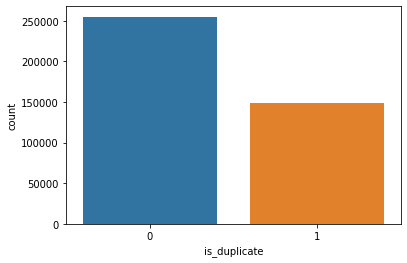

In [8]:
sns.countplot(df['is_duplicate'])      

# NUMBER OF UNIQUE QUESTION

In [9]:
ques_ids=pd.Series(df['qid1'].tolist()+df['qid2'].tolist())
ques_ids_unique=set(ques_ids)
print("The number of unique Questions  are :: {}".format(len(ques_ids_unique)))

The number of unique Questions  are :: 537933


# NUMBER OF QUESTION HAVING MULTIPLE OCCURANCE

In [10]:
value_counts=ques_ids.value_counts().to_frame()
value_counts_grt1=value_counts[value_counts[0]>1]

value_counts_grt1

0
2559    157
30782   120
4044    111
2561     88
14376    79
...     ...
208997    2
31654     2
314589    2
180156    2
187978    2

[111780 rows x 1 columns]

In [11]:
print("The number of  Questions having multiple occurance  are :: {}".format(value_counts_grt1.shape[0]))
print("The  highest occurance of a question is ::{}".format(max(value_counts_grt1[0])))

The number of  Questions having multiple occurance  are :: 111780
The  highest occurance of a question is ::157


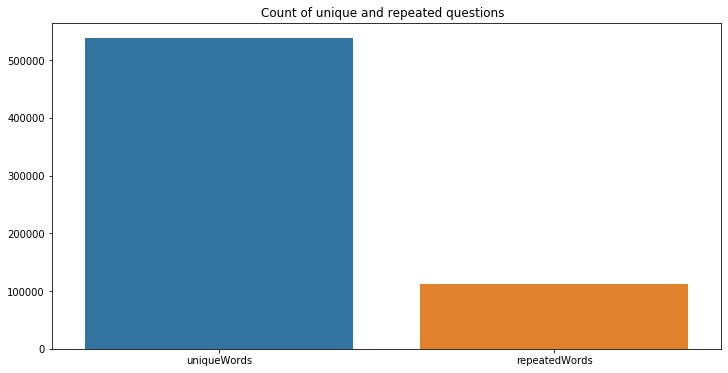

In [12]:
plt.figure(figsize=(12, 6))
plt.title ("Count of unique and repeated questions  ")
x=["uniqueWords","repeatedWords"]
y=[len(ques_ids_unique),value_counts_grt1.shape[0]]
sns.barplot(x,y)
plt.show()

# checking of duplicate pairs

In [13]:
duplicate_pairs = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count()
print("Number of duplicate pairs of question is :{}".format(df.shape[0]-duplicate_pairs.shape[0]))

Number of duplicate pairs of question is :0


# Checking for NaN values and removing the NaN values 

In [14]:
null_df=df[df.isnull().any(1)]
null_df

id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0

In [15]:
df=df.fillna('')

In [16]:
null_df=df[df.isnull().any(1)]
print(null_df)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


# Basic feature extraction

In [17]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  freq_qid1  \
0  What is the step by step guide to invest in sh...             0          1   
1  What would happen if the Indian government sto...             0          4   
2  How can Internet speed be increased by hacking...             0          1   
3  Find the remainder when [math]23^{24}[/math] i...             0          1   
4            Which fish would survive in salt water?             0          3   

   freq_qid2  q1len  q2len  q1_n_words  q2_n_words  word_Common  word_Total  \
0          1     66     57          14          12         10.0        23.0   
1          1     51     88           8          13          4.0        20.0   
2          1     73     59          14          10          4.0        24.0   
3          1     50     65          11           9          0.0        19.0   
4          1     76     39          13           7          2.0        20.0   

   word_share  freq_q1+q2  freq_q1-q2  
0    0.434783           2           0  
1    0.200000           5           3  
2    0.166667           2           0  
3    0.000000           2           0  
4    0.100000           4           2

# Summary of basic feature extraction

In [18]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


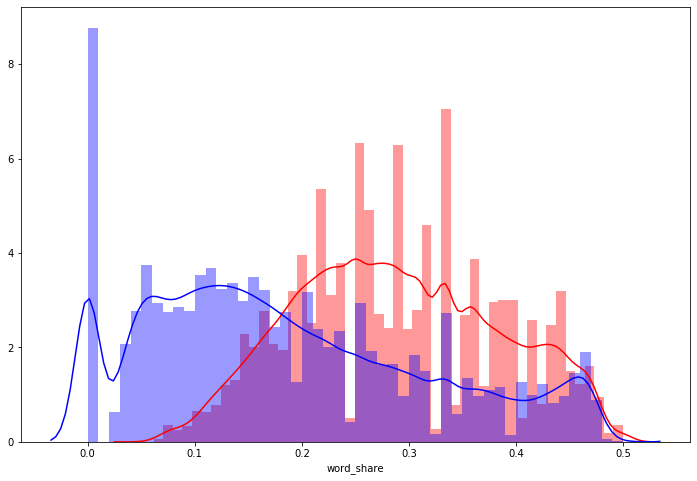

In [19]:
plt.figure(figsize=(12, 8))
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

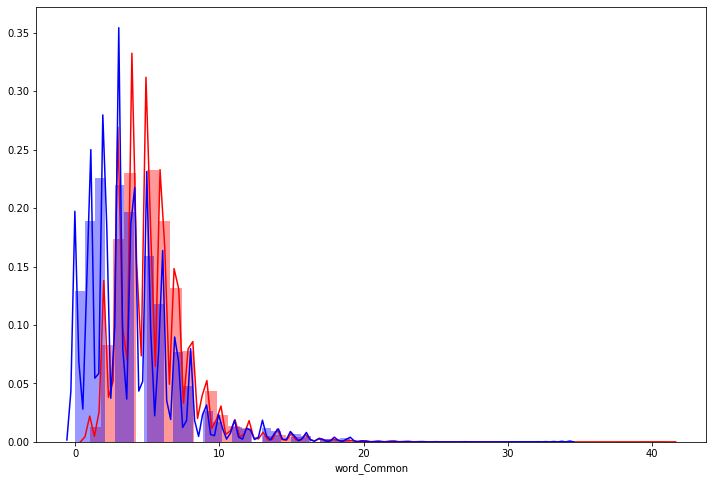

In [20]:
plt.figure(figsize=(12,8))
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

In [21]:
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x

In [22]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [23]:
if os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_csv("C:/Users/tapas/Documents/machine learninng/datasets/quora-question-pairs/train/train.csv")
    df = extract_features(df)
    df.to_csv("nlp_features_train.csv", index=False)
df.head(2)

Extracting features for train:
token features...
fuzzy features..


id  qid1  qid2                                          question1  \
0   0     1     2  what is the step by step guide to invest in sh...   
1   1     3     4  what is the story of kohinoor  koh i noor  dia...   

                                           question2  is_duplicate   cwc_min  \
0  what is the step by step guide to invest in sh...             0  0.999980   
1  what would happen if the indian government sto...             0  0.799984   

    cwc_max   csc_min   csc_max  ...   ctc_max  last_word_eq  first_word_eq  \
0  0.833319  0.999983  0.999983  ...  0.785709           0.0            1.0   
1  0.399996  0.749981  0.599988  ...  0.466664           0.0            1.0   

   abs_len_diff  mean_len  token_set_ratio  token_sort_ratio  fuzz_ratio  \
0           2.0      13.0              100                93          93   
1           5.0      12.5               86                63          66   

   fuzz_partial_ratio  longest_substr_ratio  
0                 100              0.982759  
1                  75              0.596154  

[2 rows x 21 columns]

In [24]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s',encoding='utf-8')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s',encoding='utf-8')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [25]:
# reading the text files and removing the Stop Words:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt'),encoding='utf-8').read()
textn_w = open(path.join(d, 'train_n.txt'),encoding='utf-8').read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16110077
Total number of words in non duplicate pair questions : 33193603


Word Cloud for Duplicate Question pairs


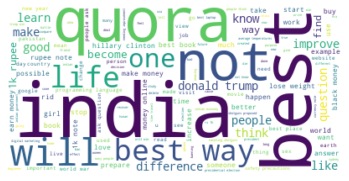

In [26]:

wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for non-Duplicate Question pairs:


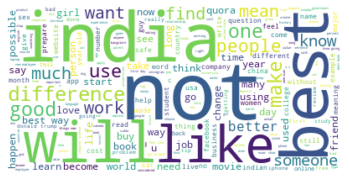

In [27]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

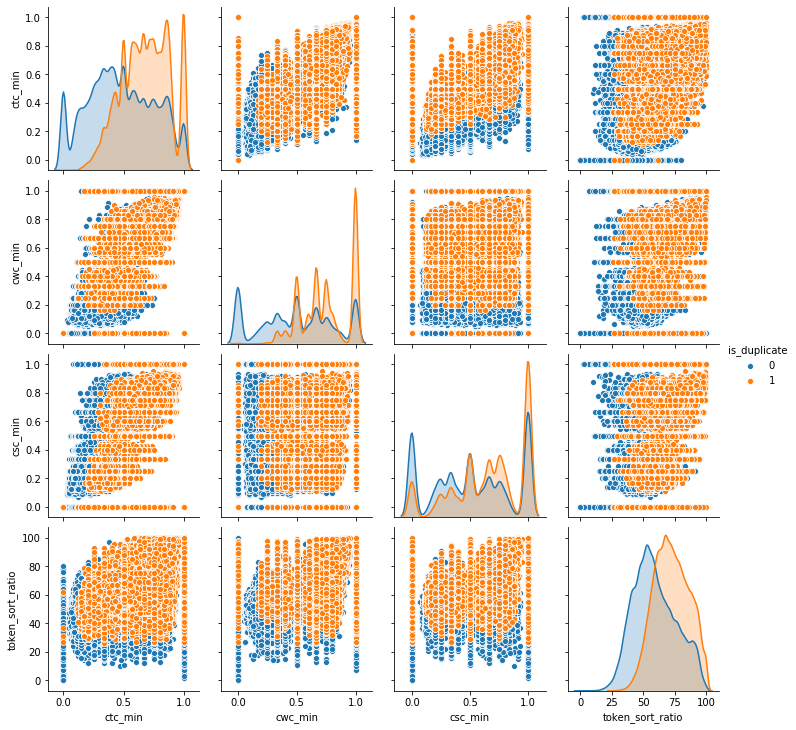

In [28]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

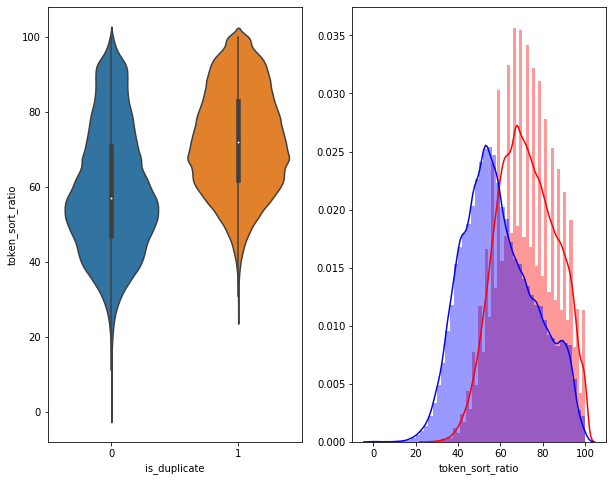

In [29]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

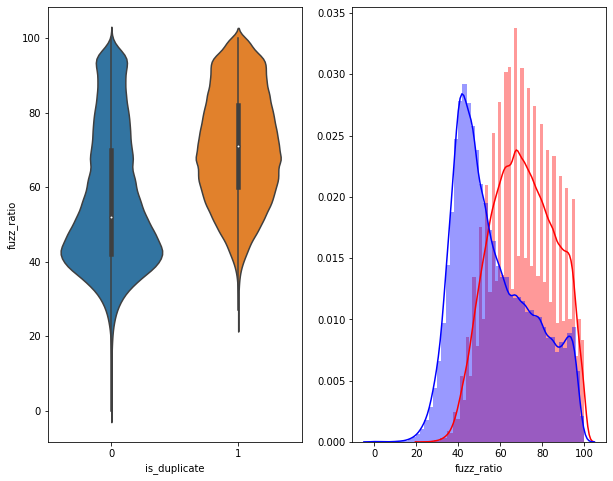

In [30]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

In [31]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [32]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.066s...
[t-SNE] Computed neighbors for 5000 samples in 0.685s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.121373
[t-SNE] Computed conditional probabilities in 0.388s
[t-SNE] Iteration 50: error = 81.0920868, gradient norm = 0.0421742 (50 iterations in 4.239s)
[t-SNE] Iteration 100: error = 70.5459442, gradient norm = 0.0093492 (50 iterations in 3.757s)
[t-SNE] Iteration 150: error = 68.7559357, gradient norm = 0.0057663 (50 iterations in 3.172s)
[t-SNE] Iteration 200: error = 67.9614410, gradient norm = 0.0038081 (50 iterations in 2.989s)
[t-SNE] Iteration 250: error = 67.4909058, gradient norm = 0.0031304

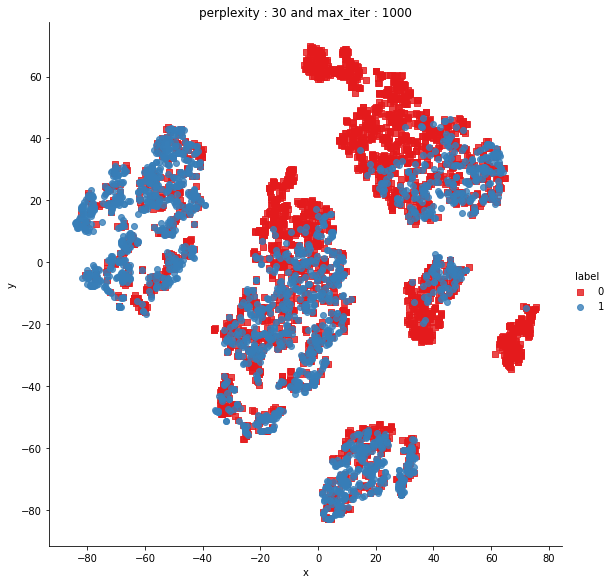

In [33]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [34]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.051s...
[t-SNE] Computed neighbors for 5000 samples in 0.780s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.121373
[t-SNE] Computed conditional probabilities in 0.396s
[t-SNE] Iteration 50: error = 80.4366913, gradient norm = 0.0314773 (50 iterations in 8.234s)
[t-SNE] Iteration 100: error = 69.3142166, gradient norm = 0.0033980 (50 iterations in 4.697s)
[t-SNE] Iteration 150: error = 67.9019623, gradient norm = 0.0017607 (50 iterations in 4.959s)
[t-SNE] Iteration 200: error = 67.3396301, gradient norm = 0.0011940 (50 iterations in 4.397s)
[t-SNE] Iteration 250: error = 67.0172043, gradient norm = 0.0009145

In [35]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

# CREATING DATA SET

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
import distance
from os import path
from wordcloud import WordCloud, STOPWORDS
from sklearn.manifold import TSNE
import plotly.graph_objs as go
import plotly.offline as py

import time
import warnings
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import sys
from tqdm import tqdm

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy
warnings.filterwarnings("ignore")

In [13]:
df = pd.read_csv("C:/Users/tapas/Documents/machine learninng/datasets/quora-question-pairs/train/train.csv")
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [14]:
df.head(10)

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   
5   5    11    12  Astrology: I am a Capricorn Sun Cap moon and c...   
6   6    13    14                                Should I buy tiago?   
7   7    15    16                     How can I be a good geologist?   
8   8    17    18                    When do you use シ instead of し?   
9   9    19    20  Motorola (company): Can I hack my Charter Moto...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0  
5  I'm a triple Capricorn (Sun, Moon and ascendan...             1  
6  What keeps childern active and far from phone ...             0  
7          What should I do to be a great geologist?             1  
8              When do you use "&" instead of "and"?             0  
9  How do I hack Motorola DCX3400 for free internet?             0

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(df['question1']) + list(df['question2'])

tfidf = TfidfVectorizer(lowercase=False,)
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [16]:
import en_core_web_md

In [17]:
# en_vectors_web_md, having 300 vectors.
nlp = en_core_web_md.load()
# nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(df['question1'])):
    doc1 = nlp(qu1)
    # 300 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    # print(doc1[0], doc1[0].vector.shape)
    for i,word1 in enumerate(doc1):
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1[i] += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)

100%|████████████████████████████████████████████████████████████████████████| 404290/404290 [1:29:06<00:00, 75.62it/s]


In [18]:
vecs2 = []
for qu2 in tqdm(list(df['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    for i,word2 in enumerate(doc2):
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2[i] += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df['q2_feats_m'] = list(vecs2)

100%|████████████████████████████████████████████████████████████████████████| 404290/404290 [1:54:00<00:00, 59.11it/s]


In [19]:

#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [20]:

df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index= df3.index)
df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index= df3.index)

In [21]:
df3_q1.head(10)

0         1         2         3         4         5         6    \
0 -0.390458  1.163304  0.324181  0.531401  1.356372 -0.367651 -0.271853   
1 -0.482770  0.694989  0.884920 -0.371616  0.397648  0.059921  0.304119   
2  0.060635  1.070020 -0.541790 -0.323219 -0.187079  0.650152  0.289999   
3 -0.380827  1.315298 -1.190382  0.080360 -0.184001 -0.003991  0.203892   
4 -0.546131  1.355591  0.635449 -0.485387 -1.334220  1.090460 -1.202049   
5  0.349898  0.793694 -0.767053  0.304270  0.437157  0.206357 -0.383960   
6 -1.595084 -0.179341 -0.760518 -0.504248  0.010206 -0.164501  0.076528   
7 -0.352584 -0.347735 -1.400793  0.527694  0.227915  0.945955  0.033944   
8  0.061409  0.205477 -0.856722 -0.285226 -0.147848  0.273839 -0.192632   
9  0.323771  0.202560  0.590482  0.084737  1.437617 -0.488592 -0.088948   

        7         8         9    ...       290       291       292       293  \
0 -0.188049  0.535268  9.773273  ... -1.158064  0.359539  0.025645 -0.557519   
1 -0.747578  0.070877  2.175647  ...  1.417714  0.140568 -1.628942  0.061143   
2 -0.341355  0.452350  7.089532  ... -1.396137  0.159932  0.577535 -0.043608   
3 -0.650092  0.198779  8.937262  ... -0.196255 -0.382422 -0.036799 -0.148474   
4 -0.087845 -1.323729  5.620351  ... -0.906340  0.436501  0.751635 -1.891064   
5  1.016095 -0.070122  8.832993  ... -0.777150  0.472599  0.595577 -0.646786   
6 -2.030381 -1.205721  0.479051  ...  0.658074 -0.345555 -0.090864 -1.486927   
7 -0.802059 -1.015553  7.522333  ...  0.704667  0.508810 -0.693161 -0.068809   
8 -0.305640 -0.288532  6.915032  ... -0.527529  0.124466 -0.435847 -0.171737   
9 -1.206525  1.692663  4.548250  ... -1.316135 -0.204152  0.068219  0.307252   

        294       295       296       297       298       299  
0 -0.125353 -0.719978 -0.866653  0.215057  0.083743  1.120485  
1  1.407581 -0.036755 -0.723654  0.614098 -0.492846  1.443244  
2  1.081373 -0.181273  0.699022 -0.073542 -0.486058  1.287617  
3  0.718155  0.198035  0.369528 -0.090999 -0.227855  0.248131  
4 -1.034460  1.029929  0.292473 -0.964601  0.107407  0.971995  
5  0.267278  0.491455 -0.656980  0.595437  0.889779  0.430132  
6  1.514481 -0.852080 -0.232679 -2.703177 -0.641030 -0.316332  
7  0.855224  0.116371 -0.295367  0.356238 -0.353442 -0.971186  
8 -0.349315  0.176400 -0.594081 -0.415367  0.493841  0.496506  
9  0.858503  0.242091 -0.310233  1.488653 -1.237632  1.356842  

[10 rows x 300 columns]

In [22]:
if not os.path.isfile('final_features.csv'):
    df3_q1['id']=df1['id']
    df3_q2['id']=df1['id']
    df1  = df1.merge(df2, on='id',how='left')
    df2  = df3_q1.merge(df3_q2, on='id',how='left')
    result  = df1.merge(df2, on='id',how='left')
    result.to_csv('final_features.csv')